# Ch2 ML End 2 End ML project

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
csv_path = '/Users/atma6951/Documents/GIS_data/Analytics/housing/housing.csv'

housing_df = pd.read_csv(csv_path)
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
housing_df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

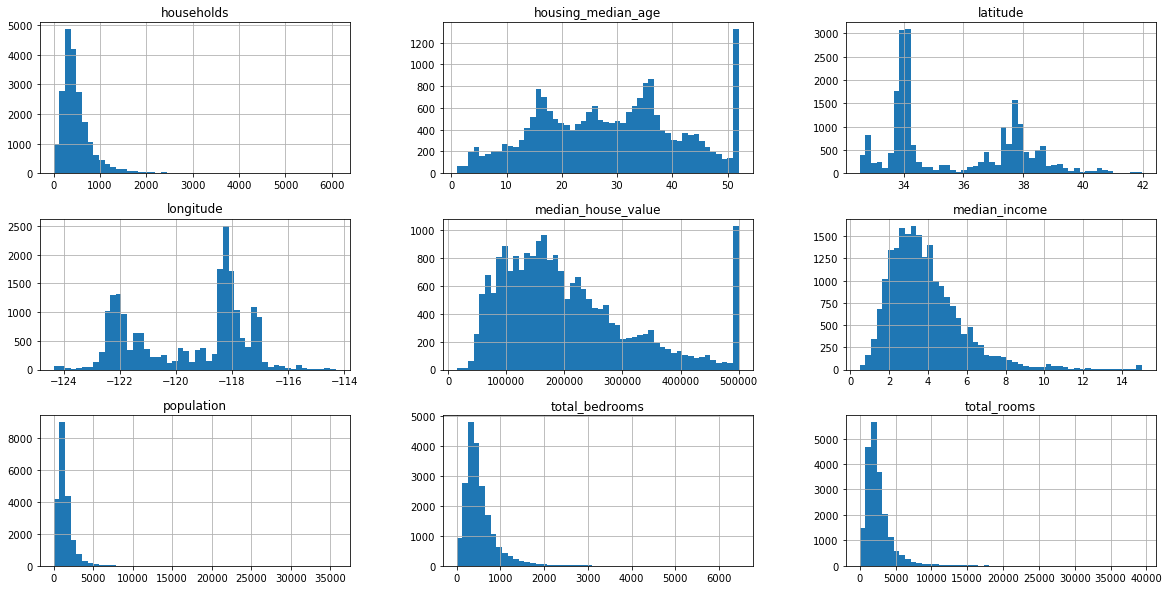

In [5]:
housing_df.hist(bins=50, figsize=(20,10));

## Data preparation

### Create stratified random sampling on income category column

In [6]:
housing_df['income_cat'] = np.ceil(housing_df['median_income'] / 1.5) # Divide by 1.5 to limit number of income cat
housing_df['income_cat'].where(housing_df['income_cat'] < 5, 5.0, inplace=True)

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sssplit.split(housing_df, housing_df['income_cat']):
    strat_test_set = housing_df.loc[test_index]
    strat_train_set = housing_df.loc[train_index]

In [9]:
strat_train_set.shape, strat_test_set.shape

((16512, 11), (4128, 11))

In [10]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

3.0    0.350594
2.0    0.318859
4.0    0.176296
5.0    0.114402
1.0    0.039850
Name: income_cat, dtype: float64

Remove the `income_cat` column

In [11]:
strat_test_set.drop('income_cat', axis=1, inplace=True)
strat_train_set.drop('income_cat', axis=1, inplace=True)

Make a copy of training data

In [12]:
housing = strat_train_set.copy()

### EDA

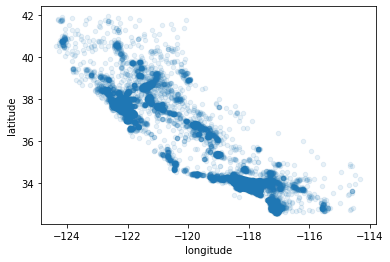

In [13]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1);

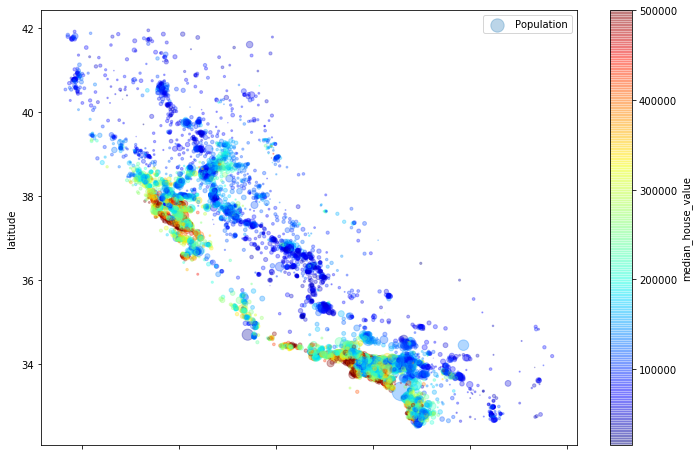

In [14]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.3, 
            s=housing['population']/100, label='Population', figsize=(12,8),
            c="median_house_value", cmap=plt.get_cmap('jet'), colorbar=True);

### Looking for correlations

In [15]:
housing.corr()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


### Feature combinations
Combine columns to discover new columns that might be better correlated with the target / label

In [16]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [17]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare data for ML algorithms

In [19]:
# start afresh
housing = strat_train_set.drop('median_house_value', axis=1, inplace=False)
housing_labels = strat_train_set['median_house_value'].copy()

### Filling missing values

In [20]:
from sklearn.preprocessing import Imputer

In [22]:
from sklearn.impute import SimpleImputer

In [25]:
imputer1 = SimpleImputer(strategy='median', verbose=1)

In [26]:
# keep only numerical columns for imputation
housing_num = housing.drop('ocean_proximity', axis=1)

# train the imputer
imputer1.fit(housing_num)
imputer1.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [27]:
# transform or fill NA
X = imputer1.transform(housing_num)
housing_tr = pd.DataFrame(X, columns = housing_num.columns)  # convert X to a dataframe

### Transform categorical columns

In [28]:
housing_cat = housing['ocean_proximity']
housing_cat.value_counts()

<1H OCEAN     7276
INLAND        5263
NEAR OCEAN    2124
NEAR BAY      1847
ISLAND           2
Name: ocean_proximity, dtype: int64

ML algos prefer numerical columns. So let us convert the categories into numbers.

In [29]:
housing_cat_encoded, housing_categories = housing_cat.factorize() # use Pandas DF Factorize
housing_cat_encoded[0:10], housing_categories[0:10]

(array([0, 0, 1, 2, 0, 2, 0, 2, 0, 0]),
 Index(['<1H OCEAN', 'NEAR OCEAN', 'INLAND', 'NEAR BAY', 'ISLAND'], dtype='object'))

This is still not sufficient as algos will think 0 and 1 are closer than 0 and 4, which may not be true.

In [30]:
from sklearn.preprocessing import OneHotEncoder
ohencoder = OneHotEncoder()

In [35]:
ohencoder.fit(housing_cat.array.reshape(-1,1))

AttributeError: 'PandasArray' object has no attribute 'reshape'